**Lab 1 CT-221**: Predição de séries temporais


**Equipe**: Victor Hugo de Oliveira Bastos, Leonardo Antônio Lugarini, José Eduardo Teixeira Araújo, Marcel Versiani, Rafael Otero

>[Preparação dos dados](#scrollTo=PVReDV-SVMVX)

>>[Importando pacotes e dados](#scrollTo=efpR3GuWVMVc)

>>[Aplicando os modelos](#scrollTo=LHNzVtsrY7AG)

>>>[[1] 10-15-1 --- r = 15, p = 0 e tanh / Levenberg-Marquardt](#scrollTo=FUZnaVtqVSCO)

>>>[[2] 10-10-10-1 --- r = 10, p = 10 e Relu / Levenberg-Marquardt](#scrollTo=Uqu36GzdVYh8)

>>>[[3] 10-10-10-3 --- r=10 , p=10, relu / Resilient Backpropapation](#scrollTo=4pekYAa4ae7l)

>>>[[4] 10-25-10 ---  r=25 (RELU) / Polak-Ribiére Conjugate Gradient](#scrollTo=H1UzQr-bVxzV)

>>>[[5] 6-25-25-2 --- r=p=25 Tanh / Bayesian Regularization](#scrollTo=fbGBxtj_XKLv)

>>>[[6] 10-25-25-1, r = p = 25, Tanh / RMSprop](#scrollTo=ziJ-KWiOb50H)

>>[Analisando os resultados](#scrollTo=iA97S80t7h18)



 <a name='prep'></a>
#Preparação dos dados



<a name='imp'></a>
## Importando pacotes e dados

In [3]:
# Importing the necessary Python libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import visualkeras
# Importing scipy.stats for Q-Q plots
import scipy.stats as stats
plt.style.use('ggplot')

# Importing train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Importing OrdinalEncoder from sklearn.compose and sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# Importing KBinsDiscretizer from sklearn.preprocessing
from sklearn.preprocessing import KBinsDiscretizer

# Importing MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

# Importing KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Importing DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Importing GaussianNB from sklearn.naive_bayes
from sklearn.naive_bayes import GaussianNB

# Importing metrics from sklearn.metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Importing GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV

# Importing PowerTransformer and FunctionTransformer from sklearn.preprocessing
from sklearn.preprocessing import PowerTransformer, FunctionTransformer

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
#from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


Por conveniência, optou-se por adquirir os dados a partir da leitura do Google Drive.

In [4]:
# Carregando os dados...

def carregar_dados(url):
  # URL dos arquivos CSV
  url_data = url
  # Extração do identificador do arquivo da URL
  identificador = url.split('/')[-2]
  # Construção do link de download direto do arquivo
  url_download = 'https://drive.google.com/uc?id=' + identificador

  #Retorna dataframe
  return pd.read_csv(url_download, on_bad_lines='skip', sep=',',parse_dates=['Date'], index_col=['Date'])


# URL dos arquivos CSV
url_data_embr = 'https://drive.google.com/file/d/1JkBgws5aVCpP9Xunv_51Pkhv8QdM6ZKT/view?usp=drive_link'
url_data_petr = 'httpsn://drive.google.com/file/d/1tvv9iIqA9bOpR31c545e59oOzbkXxmpv/view?usp=drive_link'
url_data_vale = 'https://drive.google.com/file/d/1JxYLJ9EQHnN0XGUmOBdd7as_EDsV9CKX/view?usp=drive_link'

embr = carregar_dados(url_data_embr)
petr = carregar_dados(url_data_petr)
vale = carregar_dados(url_data_vale)

companies = dict({'Petr':petr, 'Embr':embr, 'Vale':vale})

In [5]:
petr.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,16.990000,17.330000,16.980000,17.330000,6.917481,4488000
2018-01-03,17.240000,17.670000,17.209999,17.549999,7.005296,9771700
2018-01-04,17.670000,17.900000,17.629999,17.700001,7.065169,6816500
2018-01-05,17.690001,17.850000,17.600000,17.840000,7.121052,4646500
2018-01-08,17.639999,18.120001,17.610001,18.120001,7.232818,4763400


<a name='ana'></a>
## Aplicando os modelos

In [6]:
petr_close = petr[:-90]['Close']
embr_close = embr[:-90]['Close']
vale_close = vale[:-90]['Close']

In [7]:
date_index  = petr[-90:].index

<a name='ana'></a>
###[1] 10-15-1 --- r = 15, p = 0 e tanh / Levenberg-Marquardt

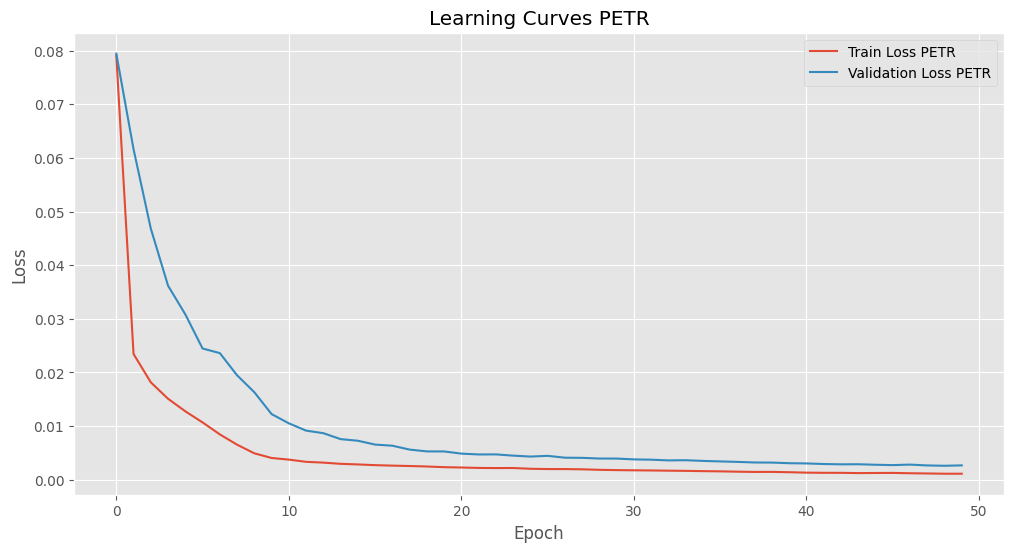

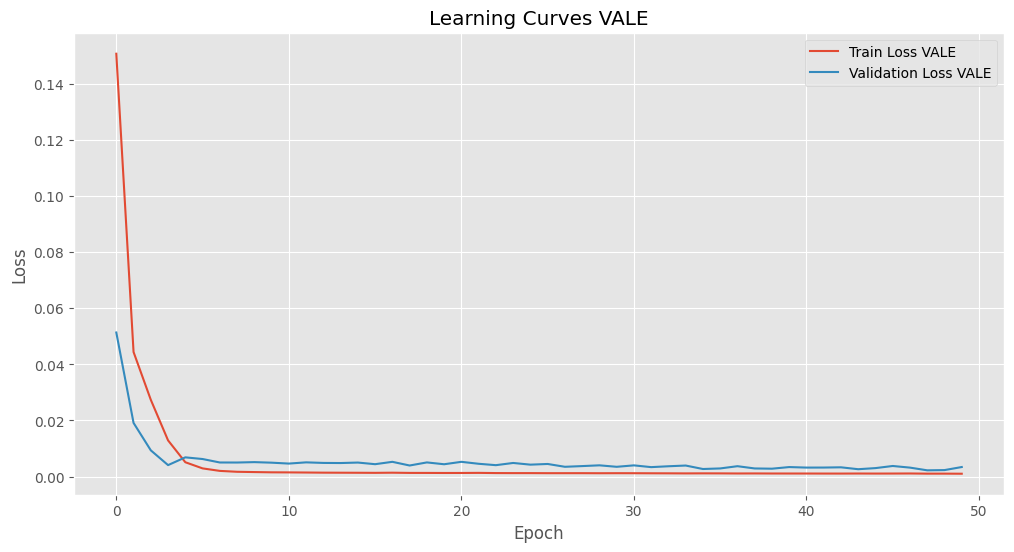

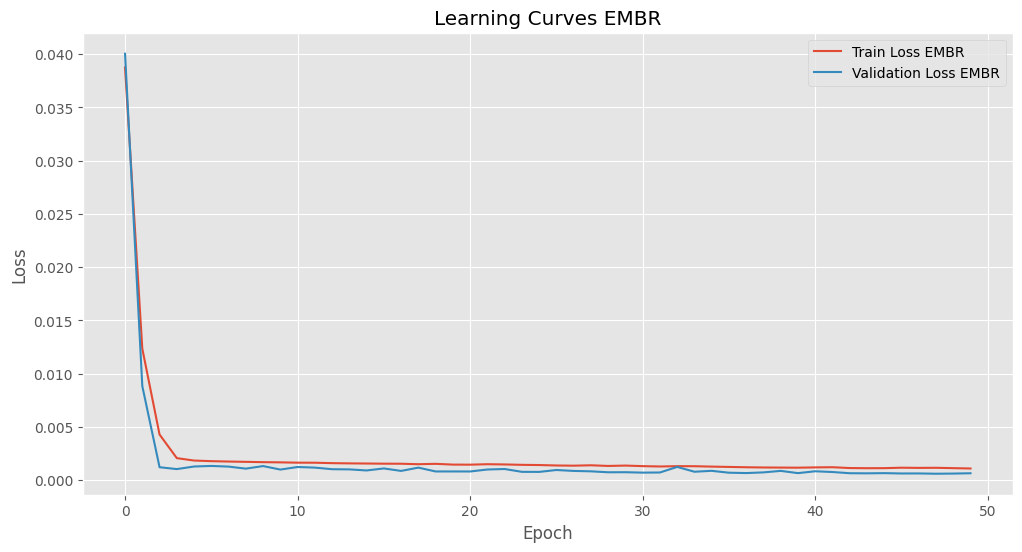

1/1 [==============================] - 0s 39ms/step


In [41]:
r_1 = 15
p_1 = 0

# Função para criar amostras NARMAX
def create_narmax_samples(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss ' + label)
    plt.plot(history.history['val_loss'], label='Validation Loss ' + label)
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_1 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_1 = MinMaxScaler()
normalized_data_1 = scaler_1.fit_transform(combined_data_1)

# Dividir os dados em treinamento e teste
train_size_1 = int(0.8 * normalized_data_1.shape[0])
train_data_1 = normalized_data_1[:train_size_1]
test_data_1 = normalized_data_1[train_size_1:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_1 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_1, y_train_1 = create_narmax_samples(train_data_1, sequence_length_1)
X_test_1, y_test_1 = create_narmax_samples(test_data_1, sequence_length_1)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR com learning curves
model_petr_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model_with_learning_curves(model_petr_1, X_train_1, y_train_1[:, 0], X_test_1, y_test_1[:, 0], label='PETR')

model_vale_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model_with_learning_curves(model_vale_1, X_train_1, y_train_1[:, 1], X_test_1, y_test_1[:, 1], label='VALE')

model_embr_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model_with_learning_curves(model_embr_1, X_train_1, y_train_1[:, 2], X_test_1, y_test_1[:, 2], label='EMBR')

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_1 = normalized_data_1[-sequence_length_1:, :]

predicted_1 = make_predictions([model_petr_1,
                              model_vale_1,
                              model_embr_1],
                              last_10_days_1, 90)

# Imprima as previsões
petr_predictions_1 = []
embr_predictions_1 = []
vale_predictions_1 = []

for i in predicted_1:
    petr_predictions_1.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_1.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_1.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))


In [9]:
plot_model(model_petr_1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [42]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_1)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_1)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_1)

Previsão para os próximos 90 dias de PETR:
[26.266764834081084, 26.197164847213628, 26.42415655041522, 26.73811254839736, 27.061735893173875, 27.375228164024232, 27.636201064027848, 27.853261732458176, 28.037144997781574, 28.206561795131087, 28.35675301115817, 28.55750866992742, 28.735212543902577, 28.90709709700829, 29.07563554061407, 29.240620561413945, 29.401337474063634, 29.55535671210015, 29.70075062548548, 29.837008205105782, 29.9645186180442, 30.083618293788494, 30.198337112040758, 30.307691243866504, 30.411420638364376, 30.509356171521603, 30.601423283289552, 30.687651070272565, 30.768137733510315, 30.84300875210905, 30.91247689498806, 30.976818579888644, 31.036306587476552, 31.09133554044825, 31.142207316073836, 31.18917650964135, 31.232488623749973, 31.272360064394533, 31.309001781956553, 31.342622908279775, 31.373427119594634, 31.40161263651824, 31.427384953818798, 31.45092956234902, 31.472422860272765, 31.492033971602797, 31.509917472049715, 31.52622066317302, 31.5410599313

<a name='ana'></a>
###[2] 10-10-10-1 --- r = 10, p = 10 e Relu / Levenberg-Marquardt

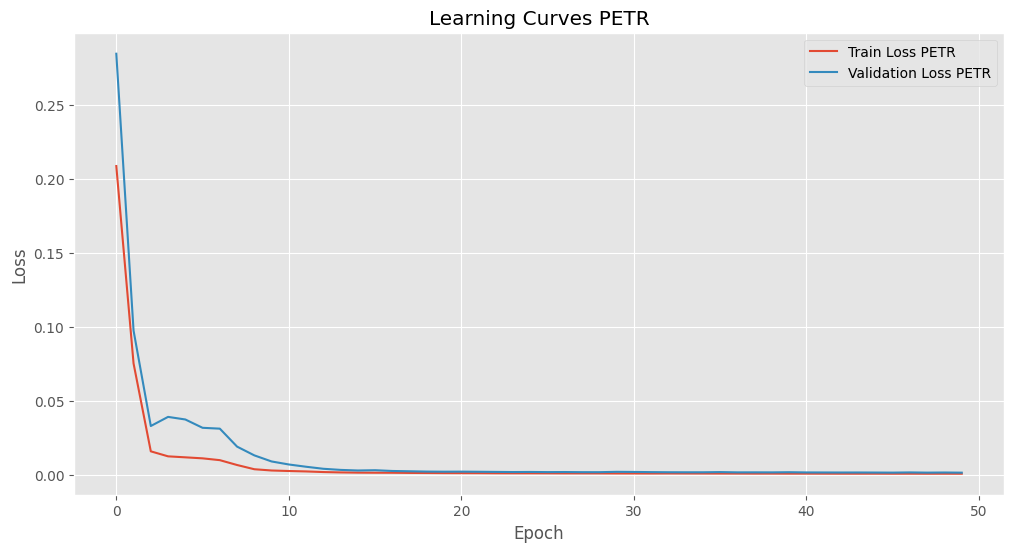

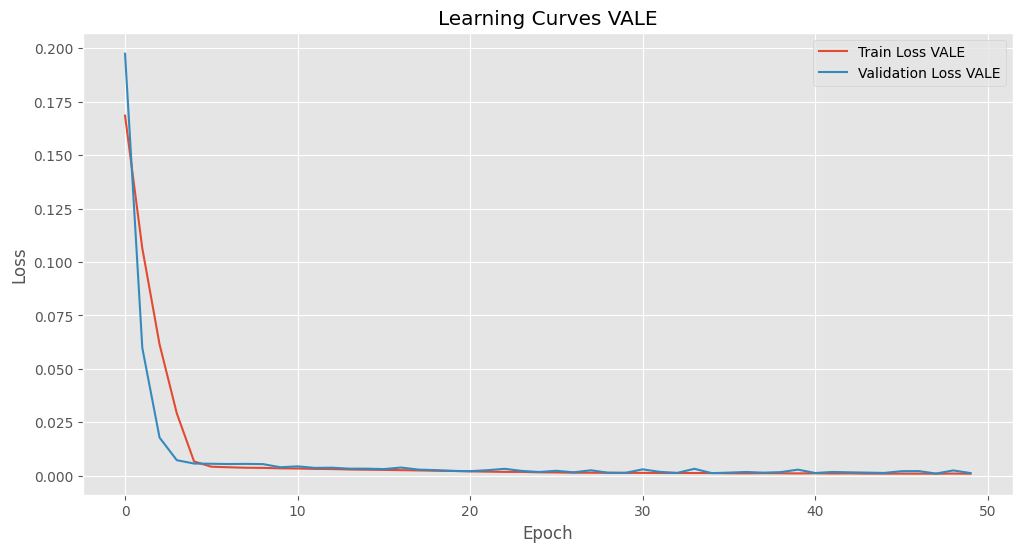

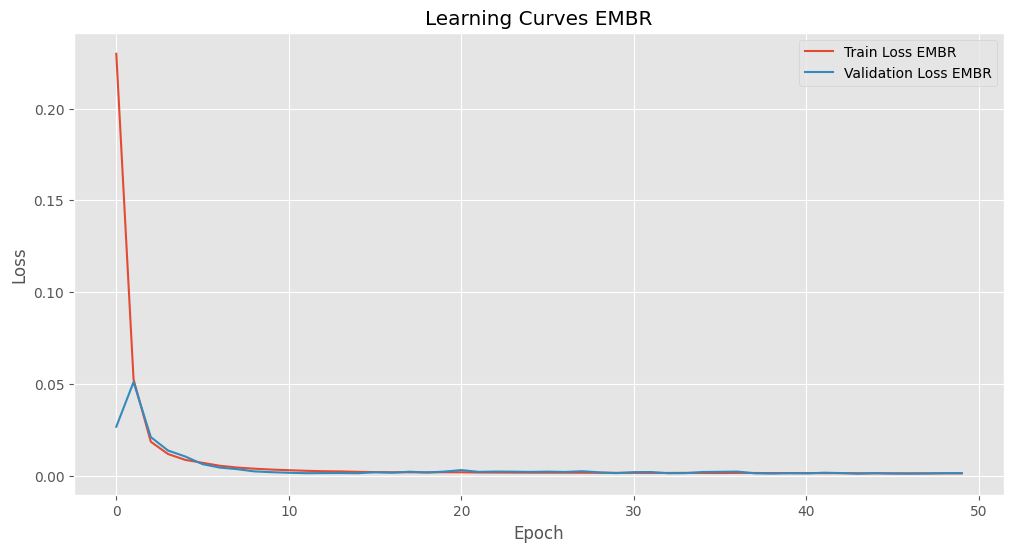

1/1 [==============================] - 0s 36ms/step


In [54]:
# Renamed variables
r_2 = 10
p_2 = 10

# Função para criar amostras NARMAX
def create_narmax_samples_2(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_2(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(p, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_2(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss ' + label)
    plt.plot(history.history['val_loss'], label='Validation Loss ' + label)
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_2 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_2 = MinMaxScaler()
normalized_data_2 = scaler_2.fit_transform(combined_data_2)

# Dividir os dados em treinamento e teste
train_size_2 = int(0.8 * normalized_data_2.shape[0])
train_data_2 = normalized_data_2[:train_size_2]
test_data_2 = normalized_data_2[train_size_2:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_2 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_2, y_train_2 = create_narmax_samples_2(train_data_2, sequence_length_2)
X_test_2, y_test_2 = create_narmax_samples_2(test_data_2, sequence_length_2)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR com learning curves
model_petr_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_with_learning_curves_2(model_petr_2, X_train_2, y_train_2[:, 0], X_test_2, y_test_2[:, 0], label='PETR')

model_vale_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_with_learning_curves_2(model_vale_2, X_train_2, y_train_2[:, 1], X_test_2, y_test_2[:, 1], label='VALE')

model_embr_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_with_learning_curves_2(model_embr_2, X_train_2, y_train_2[:, 2], X_test_2, y_test_2[:, 2], label='EMBR')

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_2 = normalized_data_2[-sequence_length_2:, :]

predicted_2 = make_predictions_2([model_petr_2,
                              model_vale_2,
                              model_embr_2],
                              last_10_days_2, 90)

# Imprima as previsões
petr_predictions_2 = []
embr_predictions_2 = []
vale_predictions_2 = []

for i in predicted_2:
    petr_predictions_2.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_2.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_2.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

In [12]:
plot_model(model_petr_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [57]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_2)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_2)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_2)

Previsão para os próximos 90 dias de PETR:
[26.70213459712201, 26.5736021659559, 26.487277996470986, 26.481947862262132, 26.575435252029777, 26.70135444441795, 26.864811893489602, 27.019365781630995, 27.18147751275158, 27.320977545218824, 27.434303363537968, 27.56575091075212, 27.6932249529351, 27.816907343864084, 27.936707156650485, 28.057565358420014, 28.177483376161575, 28.297728730702044, 28.418237773219406, 28.539617895329418, 28.661801811134517, 28.78476587964368, 28.9093648136096, 29.035718636525214, 29.163969194336712, 29.294374719407678, 29.427173440186202, 29.562541754836143, 29.70077244793874, 29.842181945066272, 29.987010293204605, 30.127837858245194, 30.26761248991597, 30.404275603459357, 30.538281833318294, 30.670835051497637, 30.801993451206087, 30.933439179882466, 31.064079296325982, 31.19384651463908, 31.322799028030456, 31.449885721668064, 31.575304816169023, 31.69977099687761, 31.823420654126704, 31.946428367542385, 32.0687850444358, 32.190541603864546, 32.3117762429

<a name='ana'></a>
###[3] 10-10-10-3 --- r=10 , p=10, relu / Resilient Backpropapation

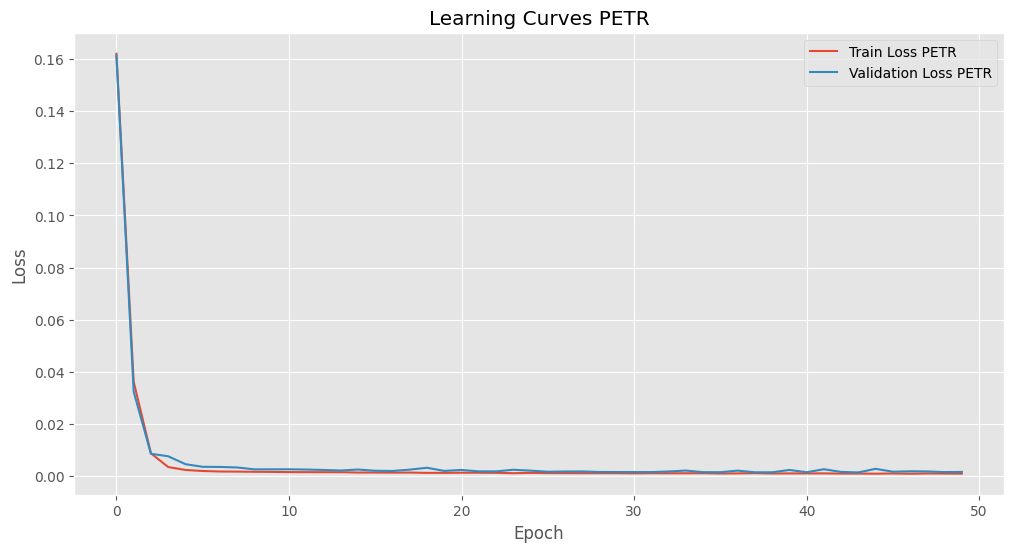

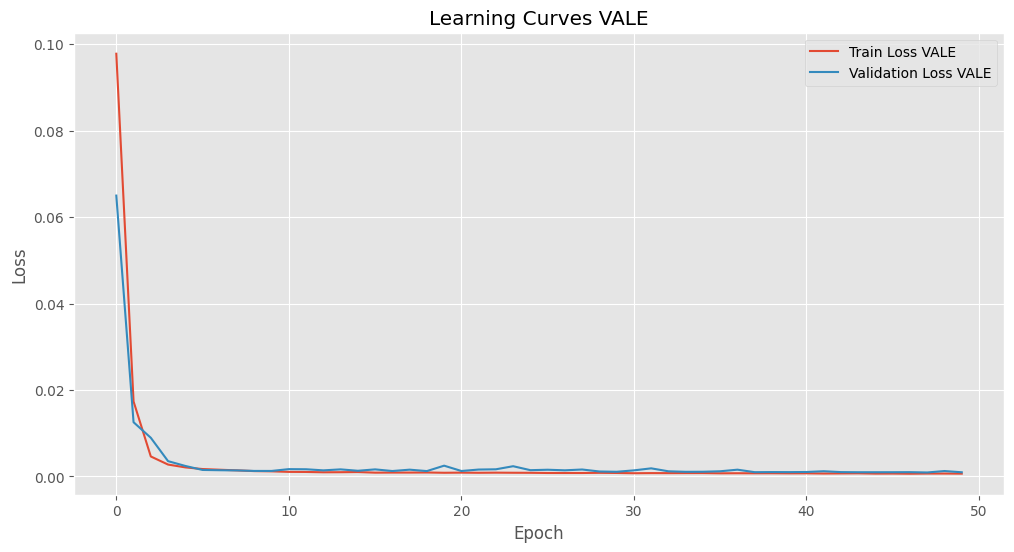

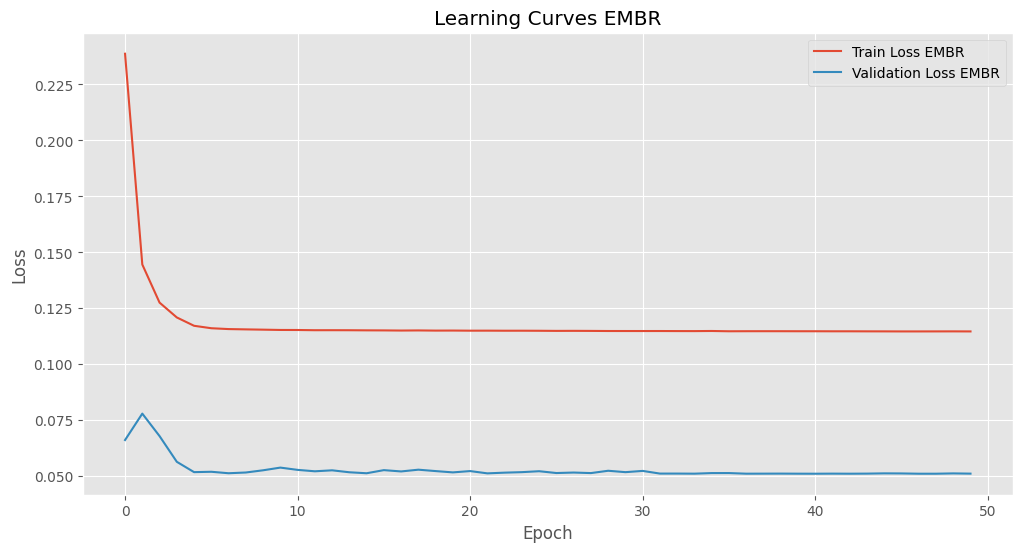

1/1 [==============================] - 0s 41ms/step


In [47]:
# Renamed variables
r_3 = 10
p_3 = 10

# Função para criar amostras NARMAX
def create_narmax_samples_3(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_3(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(p, activation='relu'),
        tf.keras.layers.Dense(3, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_3(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss ' + label)
    plt.plot(history.history['val_loss'], label='Validation Loss ' + label)
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_3 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_3 = MinMaxScaler()
normalized_data_3 = scaler_3.fit_transform(combined_data_3)

# Dividir os dados em treinamento e teste
train_size_3 = int(0.8 * normalized_data_3.shape[0])
train_data_3 = normalized_data_3[:train_size_3]
test_data_3 = normalized_data_3[train_size_3:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_3 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_3, y_train_3 = create_narmax_samples_3(train_data_3, sequence_length_3)
X_test_3, y_test_3 = create_narmax_samples_3(test_data_3, sequence_length_3)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_rp_3
model_petr_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_with_learning_curves_3(model_petr_3, X_train_3, y_train_3[:, 0], X_test_3, y_test_3[:, 0], label='PETR')

model_vale_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_with_learning_curves_3(model_vale_3, X_train_3, y_train_3[:, 1], X_test_3, y_test_3[:, 1], label='VALE')

model_embr_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_with_learning_curves_3(model_embr_3, X_train_3, y_train_3[:, 2], X_test_3, y_test_3[:, 2], label='EMBR')


# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_3 = normalized_data_3[-sequence_length_3:, :]

predicted_3 = make_predictions_3([model_petr_3,
                              model_vale_3,
                              model_embr_3],
                              last_10_days_3, 90)

# Imprima as previsões
petr_predictions_3 = []
embr_predictions_3 = []
vale_predictions_3 = []

for i in predicted_3:
    petr_predictions_3.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_3.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_3.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

In [15]:
plot_model(model_petr_3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [48]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_3)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_3)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_3)

Previsão para os próximos 90 dias de PETR:
[26.703162070963025, 27.029986042217732, 27.47849201285255, 27.92195699678421, 28.436454066078543, 28.967287060176076, 29.525570881937444, 30.10596266738939, 30.66950206331098, 31.26907396664107, 31.8686495070467, 32.49384097050452, 33.1270812821399, 33.77242578118372, 34.429999946742235, 35.09980741589099, 35.784006792964995, 36.482250737249856, 37.19597953066075, 37.925173169282196, 38.670962783608196, 39.43363570260668, 40.21384659987545, 41.01222832655907, 41.829410096726534, 42.665762892083286, 43.53932297024906, 44.502486041502124, 45.57600162181758, 46.77169748086261, 48.11828105590129, 49.658055172578926, 51.44349555683577, 53.542990140114426, 56.05125564371622, 59.092843719624994, 62.76006698220789, 67.1285511432389, 72.47304088926673, 79.19397823762012, 87.87273880268549, 99.24593949426841, 114.11463892665243, 134.7552172150941, 164.48429445101883, 209.4563116444416, 280.1903313921814, 396.08655828765967, 591.4059820802993, 934.06772

<a name='ana'></a>
###[4] 10-25-10 ---  r=25 (RELU) / Polak-Ribiére Conjugate Gradient

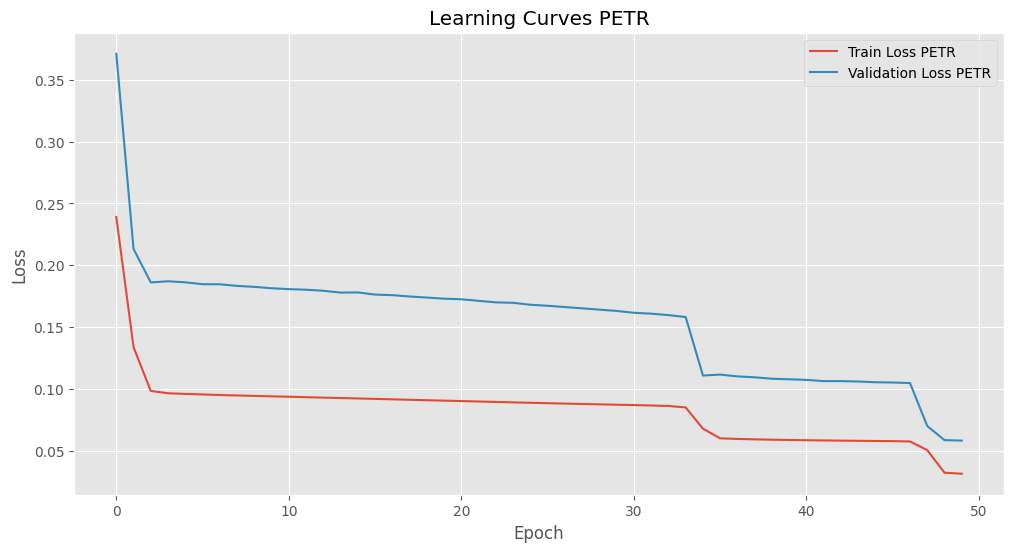

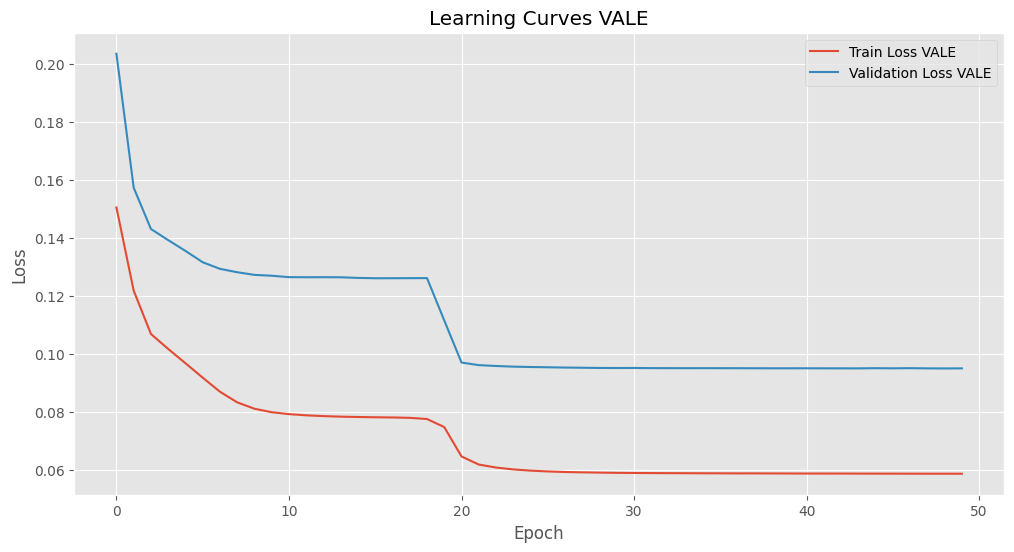

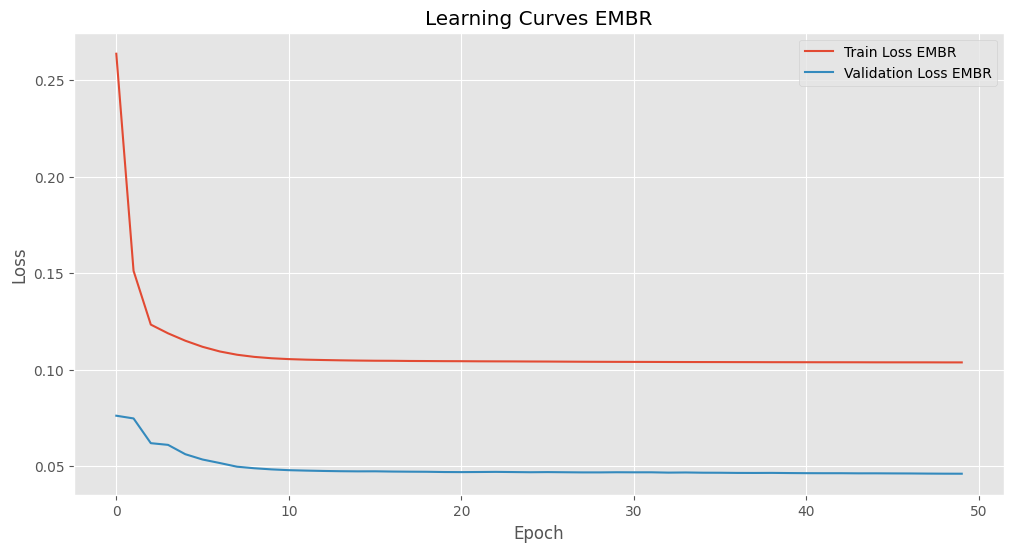

1/1 [==============================] - 0s 34ms/step


In [50]:
# Renamed variables
r_4 = 25
p_4 = 0

# Função para criar amostras NARMAX
def create_narmax_samples_4(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_4(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(10, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_4(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss ' + label)
    plt.plot(history.history['val_loss'], label='Validation Loss ' + label)
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_4 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_4 = MinMaxScaler()
normalized_data_4 = scaler_4.fit_transform(combined_data_4)

# Dividir os dados em treinamento e teste
train_size_4 = int(0.8 * normalized_data_4.shape[0])
train_data_4 = normalized_data_4[:train_size_4]
test_data_4 = normalized_data_4[train_size_4:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_4 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_4, y_train_4 = create_narmax_samples_4(train_data_4, sequence_length_4)
X_test_4, y_test_4 = create_narmax_samples_4(test_data_4, sequence_length_4)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_cgp_4
model_petr_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_with_learning_curves_4(model_petr_4, X_train_4, y_train_4[:, 0], X_test_4, y_test_4[:, 0], label='PETR')

model_vale_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_with_learning_curves_4(model_vale_4, X_train_4, y_train_4[:, 1], X_test_4, y_test_4[:, 1], label='VALE')

model_embr_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_with_learning_curves_4(model_embr_4, X_train_4, y_train_4[:, 2], X_test_4, y_test_4[:, 2], label='EMBR')


# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_4 = normalized_data_4[-sequence_length_4:, :]

predicted_4 = make_predictions_4([model_petr_4,
                              model_vale_4,
                              model_embr_4],
                              last_10_days_4, 90)

# Imprima as previsões
petr_predictions_4 = []
embr_predictions_4 = []
vale_predictions_4 = []

for i in predicted_4:
    petr_predictions_4.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_4.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_4.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

In [18]:
plot_model(model_petr_4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [53]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_4)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_4)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_4)

Previsão para os próximos 90 dias de PETR:
[26.734353630823257, 26.968621303649428, 26.80455282588649, 26.62390292072117, 26.454895294370296, 26.33729591228765, 26.259779830499976, 26.228098174710276, 26.204723599461705, 26.165424088946345, 26.107406369146855, 26.052633830000968, 26.01028735944912, 25.974824963632045, 25.947411415992526, 25.932262996354254, 25.925204341993393, 25.924070483692738, 25.92556441247219, 25.925950851748674, 25.924377816576154, 25.920108799157084, 25.91451406770244, 25.907537247541306, 25.89934291634202, 25.89007292005077, 25.880598338260207, 25.87023540076816, 25.858972287079126, 25.847113602269857, 25.83515944422758, 25.82337350092918, 25.81199945643607, 25.801129146905723, 25.790809854320198, 25.78104612502393, 25.77185068878132, 25.76356633996233, 25.75572389582187, 25.74826152607569, 25.741089213104097, 25.73419059006715, 25.72751928425166, 25.721030741482227, 25.714656766592412, 25.708401905926642, 25.702257066796065, 25.69621861212513, 25.6902756306872

<a name='ana'></a>
###[5] 6-25-25-2 --- r=p=25 Tanh / Bayesian Regularization

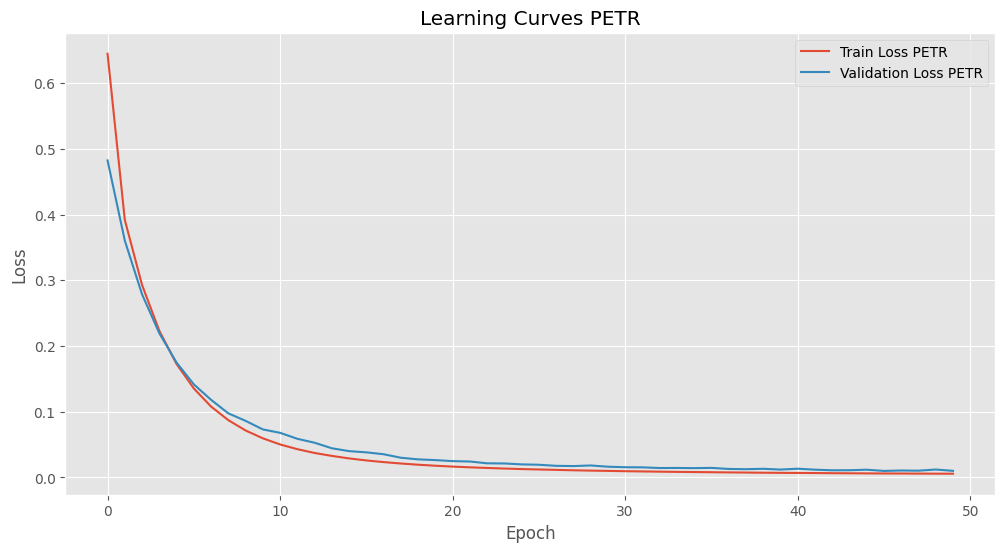

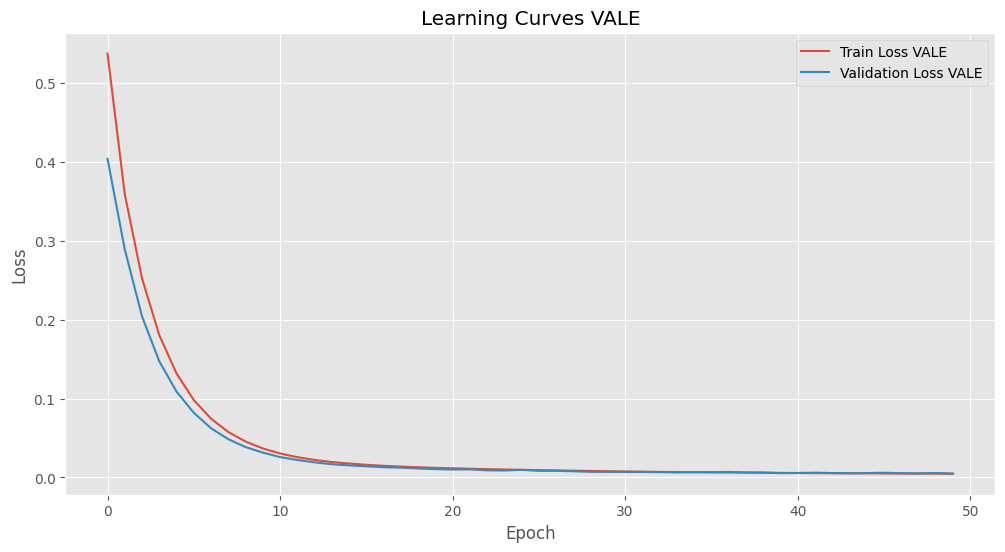

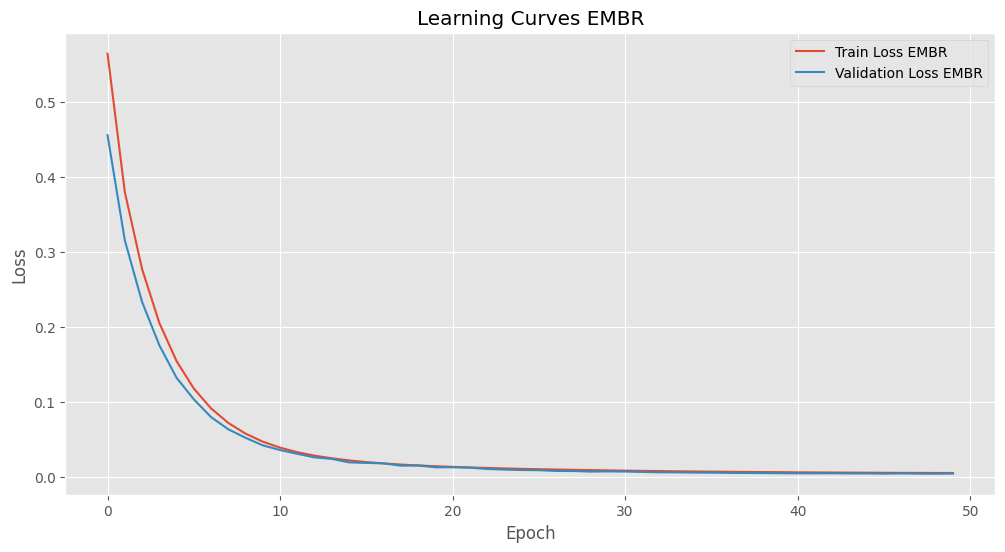

1/1 [==============================] - 0s 47ms/step


In [52]:
# Renamed variables
r_5 = 25
p_5 = 25

# Função para criar amostras NARMAX
def create_narmax_samples_5(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX com Bayesian Regularization
def create_narmax_model_5(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features),
                             kernel_regularizer=tf.keras.regularizers.L2(0.01),
                             recurrent_regularizer=tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dense(p, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dense(2, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_5(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(model.history.history['loss'], label='Train Loss ' + label)
    plt.plot(model.history.history['val_loss'], label='Validation Loss ' + label)
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_5 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_5 = MinMaxScaler()
normalized_data_5 = scaler_5.fit_transform(combined_data_5)

# Dividir os dados em treinamento e teste
train_size_5 = int(0.8 * normalized_data_5.shape[0])
train_data_5 = normalized_data_5[:train_size_5]
test_data_5 = normalized_data_5[train_size_5:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_5 = 6

# Crie amostras NARMAX para treinamento e teste
X_train_5, y_train_5 = create_narmax_samples_5(train_data_5, sequence_length_5)
X_test_5, y_test_5 = create_narmax_samples_5(test_data_5, sequence_length_5)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_br_5
model_petr_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_with_learning_curves_5(model_petr_5, X_train_5, y_train_5[:, 0], X_test_5, y_test_5[:, 0], label='PETR')

model_vale_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_with_learning_curves_5(model_vale_5, X_train_5, y_train_5[:, 1], X_test_5, y_test_5[:, 1], label='VALE')

model_embr_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_with_learning_curves_5(model_embr_5, X_train_5, y_train_5[:, 2], X_test_5, y_test_5[:, 2], label='EMBR')

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_5 = normalized_data_5[-sequence_length_5:, :]

predicted_5 = make_predictions_5([model_petr_5,
                              model_vale_5,
                              model_embr_5],
                              last_10_days_5, 90)

# Imprima as previsões
petr_predictions_5 = []
embr_predictions_5 = []
vale_predictions_5 = []

for i in predicted_5:
    petr_predictions_5.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_5.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_5.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

In [21]:
plot_model(model_petr_5, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_5)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_5)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_5)

Previsão para os próximos 90 dias de PETR:
[26.984369840752365, 26.892999228950977, 26.865150141515137, 26.94356912730646, 27.049749910720585, 27.154124886127413, 27.375271808930755, 27.43237571349996, 27.512691434187175, 27.609761343365072, 27.708940756358146, 27.806376191628157, 27.902311333236515, 27.97851897709745, 28.0574635203048, 28.135969795909165, 28.211393649990498, 28.282994937675713, 28.350509970987915, 28.413575042372763, 28.474505150413634, 28.532629254672766, 28.58764729641783, 28.639592009328723, 28.688608876427175, 28.73488702564144, 28.77869923763728, 28.820012778734803, 28.858896753369333, 28.89546209234494, 28.929837911843418, 28.96214241681993, 28.99248653807855, 29.020952109818996, 29.047631877467634, 29.072629497677447, 29.09603407879925, 29.11794200333494, 29.13843510548425, 29.15758612675804, 29.17548417550713, 29.192200174704613, 29.20780868439913, 29.22237335341269, 29.235959649105073, 29.248629401760518, 29.260442623125492, 29.271450232257603, 29.28170678529

<a name='ana'></a>
###[6] 10-25-25-1, r = p = 25, Tanh / RMSprop

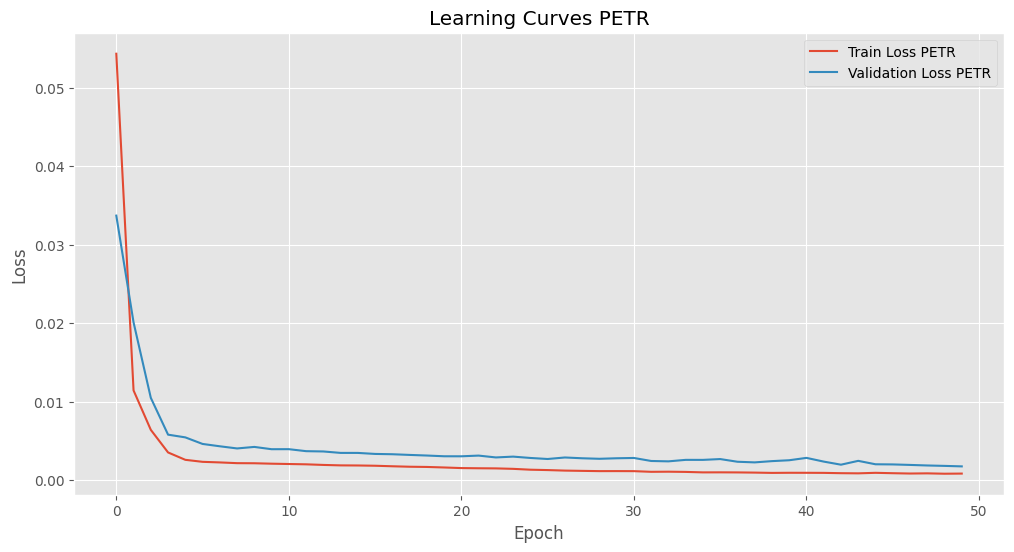

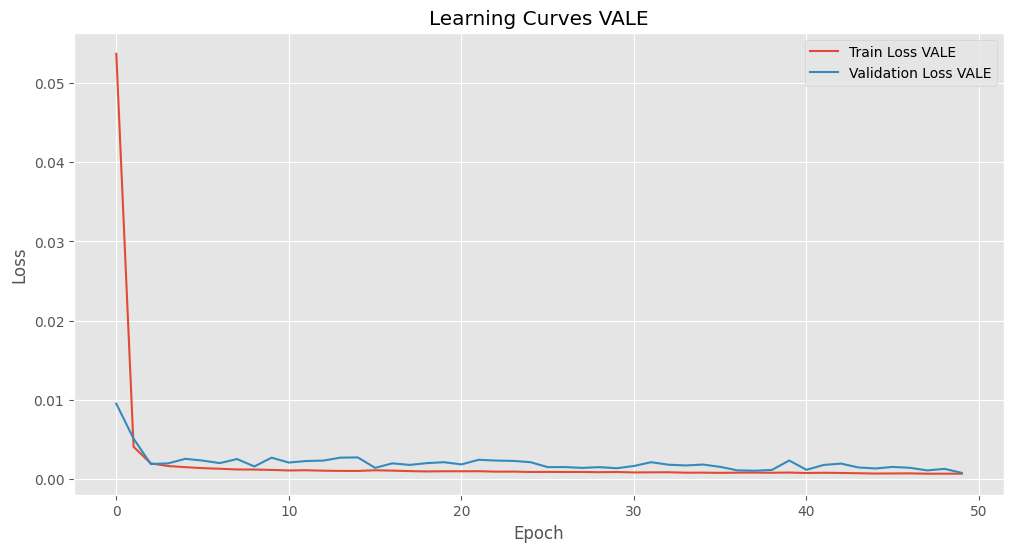

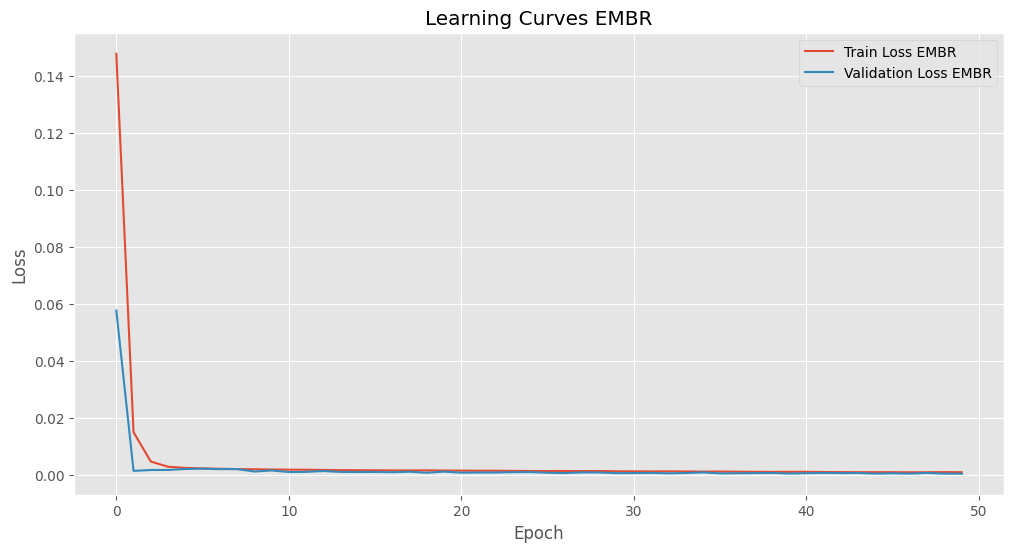

1/1 [==============================] - 0s 53ms/step


In [55]:
# Renamed variables
r_6 = 25
p_6 = 25

# Função para criar amostras NARMAX
def create_narmax_samples_6(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_6(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
    tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features)),
    tf.keras.layers.Dense(p, activation='tanh'),
    tf.keras.layers.Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_6(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(model.history.history['loss'], label='Train Loss ' + label)
    plt.plot(model.history.history['val_loss'], label='Validation Loss ' + label)
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_6 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_6 = MinMaxScaler()
normalized_data_6 = scaler_6.fit_transform(combined_data_6)

# Dividir os dados em treinamento e teste
train_size_6 = int(0.8 * normalized_data_6.shape[0])
train_data_6 = normalized_data_6[:train_size_6]
test_data_6 = normalized_data_6[train_size_6:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_6 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_6, y_train_6 = create_narmax_samples_6(train_data_6, sequence_length_6)
X_test_6, y_test_6 = create_narmax_samples_6(test_data_6, sequence_length_6)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_rp_6
model_petr_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_with_learning_curves_6(model_petr_6, X_train_6, y_train_6[:, 0], X_test_6, y_test_6[:, 0], label='PETR')

model_vale_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_with_learning_curves_6(model_vale_6, X_train_6, y_train_6[:, 1], X_test_6, y_test_6[:, 1], label='VALE')

model_embr_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_with_learning_curves_6(model_embr_6, X_train_6, y_train_6[:, 2], X_test_6, y_test_6[:, 2], label='EMBR')

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_6 = normalized_data_6[-sequence_length_6:, :]

predicted_6 = make_predictions_6([model_petr_6,
                              model_vale_6,
                              model_embr_6],
                              last_10_days_6, 90)

# Imprima as previsões
petr_predictions_6 = []
embr_predictions_6 = []
vale_predictions_6 = []

for i in predicted_6:
    petr_predictions_6.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_6.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_6.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

In [24]:
plot_model(model_petr_6, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [56]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_6)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_6)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_6)

Previsão para os próximos 90 dias de PETR:
[26.085993996153952, 26.014560013943733, 26.096758830493542, 26.271311178510338, 26.505230601353226, 26.766432637116075, 27.044086984099508, 27.325827585455954, 27.615156944933712, 27.914386424040615, 28.201540812343417, 28.51560774112964, 28.822145923541008, 29.118740341416718, 29.40359791651386, 29.675578425649583, 29.933261590824188, 30.175401713664055, 30.400691265511334, 30.608190062338053, 30.797372546728194, 30.967567678243995, 31.11918280934632, 31.25279805358434, 31.369248119795262, 31.469524111064672, 31.55474079104662, 31.62610203174597, 31.6848753539896, 31.73235373813319, 31.76980470500362, 31.798490319814444, 31.819581720890643, 31.834210038726212, 31.843391835935535, 31.84807093362212, 31.84908567769873, 31.84718166865176, 31.84301176154125, 31.837152432840824, 31.830089232135535, 31.82222951188624, 31.813922431345105, 31.805446226791204, 31.797026396908223, 31.788833884246706, 31.781008716215073, 31.773638182626367, 31.76679684

## Analisando os resultados

In [26]:
df = pd.DataFrame(petr_predictions_1, index=date_index)
df.columns = ['Petr-pred1']

df['Embr-pred1'] = embr_predictions_1
df['Vale-pred1'] = vale_predictions_1
df['Petr-pred2'] = petr_predictions_2
df['Embr-pred2'] = embr_predictions_2
df['Vale-pred2'] = vale_predictions_2
df['Petr-pred3'] = petr_predictions_3
df['Embr-pred3'] = embr_predictions_3
df['Vale-pred3'] = vale_predictions_3
df['Petr-pred4'] = petr_predictions_4
df['Embr-pred4'] = embr_predictions_4
df['Vale-pred4'] = vale_predictions_4
df['Petr-pred5'] = petr_predictions_5
df['Embr-pred5'] = embr_predictions_5
df['Vale-pred5'] = vale_predictions_5
df['Petr-pred6'] = petr_predictions_6
df['Embr-pred6'] = embr_predictions_6
df['Vale-pred6'] = vale_predictions_6

df = df.reset_index()
df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')

df

,Date,Petr-pred1,Embr-pred1,Vale-pred1,Petr-pred2,Embr-pred2,Vale-pred2,Petr-pred3,Embr-pred3,Vale-pred3,Petr-pred4,Embr-pred4,Vale-pred4,Petr-pred5,Embr-pred5,Vale-pred5,Petr-pred6,Embr-pred6,Vale-pred6
0,2023-03-21,27.210369,18.100427,90.863341,25.971070,17.748663,90.780114,25.975247,6.03,89.438296,26.608594,17.202177,87.395307,26.984370,18.514795,89.656035,26.618220,18.532722,92.393088
1,2023-03-22,27.498634,18.405204,90.093559,25.884252,18.359957,87.796148,26.056608,6.03,74.599956,26.595145,17.312315,86.231029,26.892999,18.665781,89.656226,27.046016,19.146658,90.346306
2,2023-03-23,27.664412,18.761993,89.330219,25.876114,18.441875,86.489536,25.992528,6.03,64.217035,26.502610,17.399451,85.473751,26.865150,18.864763,89.269245,27.536474,19.453895,89.899683
3,2023-03-24,27.845355,19.100401,88.699221,25.905249,18.469169,85.469655,25.718808,6.03,54.516863,26.422009,17.464508,84.861319,26.943569,19.154789,88.971013,28.063621,19.686046,90.005284
4,2023-03-27,28.075438,19.406920,88.467158,25.920977,18.436542,84.744511,25.305427,6.03,47.718381,26.341271,17.510091,84.035809,27.049750,19.424357,88.483914,28.614338,19.888843,90.466226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2023-07-24,33.911844,20.301145,90.935537,24.613749,13.704245,64.448551,17.432126,6.03,34.099998,21.557127,11.958604,56.994054,29.408479,20.346061,91.879494,33.474626,21.541497,96.657197
86,2023-07-25,33.910622,20.295839,90.914444,24.602982,13.652949,64.240441,17.432116,6.03,34.099998,21.522662,11.934133,56.885339,29.409097,20.346092,91.879615,33.474626,21.541505,96.657237
87,2023-07-26,33.909405,20.290709,90.894062,24.591841,13.601139,64.030472,17.432106,6.03,34.099998,21.489133,11.910463,56.780162,29.409670,20.346122,91.879721,33.474624,21.541514,96.657267
88,2023-07-27,33.908194,20.285754,90.874366,24.580317,13.548832,63.818678,17.432099,6.03,34.099998,21.456527,11.887573,56.678434,29.410197,20.346147,91.879807,33.474626,21.541519,96.657293


In [62]:
colors = [
    '#003f5c',
    '#444e86',
    '#955196',
    '#dd5182',
    '#ff6e54',
    '#ffa600',
]
indice = 'Petr'
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=companies[indice].index, y=companies[indice].Close, name = 'Real Close',
                         line=dict(color='royalblue', width=1)))

for i in range(0, 6):
    pred = df.loc[:, df.columns.str.startswith(indice)].columns[i]
    fig.add_trace(go.Scatter(x=df.Date, y=df[pred], name=pred,
                            line=dict(color = colors[i])
                            )
                )

layout = dict(
        title=f'Real close and Predicition for {indice}',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    #change the count to desired amount of months.
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=3,
                         label='3m',
                         step='month',
                         stepmode='backward'),
                    dict(count=5,
                         label='5m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),      
                    dict(count=12,
                         label='1y',
                         step='month',
                         stepmode='backward'),                                               
                    dict(step='all')
                ])
            ),
            rangeslider=dict(
                visible = True
            ),
            type='date'
        )
    )

fig.layout = layout
fig.show()